# GISTDA Wildfire Unsupervised Detection

## **Sentinel-2 Zip Extraction and JP2 File Processing**
This Jupyter Notebook describes the Python script for extracting Sentinel-2 zip files and processing JP2 images efficiently.

This script automates:
1. Extracting Sentinel-2 zip files while maintaining correct folder structures.
2. Extracting and organizing the highest-resolution **JP2** images for bands **(B01–B12, B8A)**.
3. Copying the **Scene Classification Layer (SCL)** files at **20m resolution**.
4. Handling nested folder issues that occur in `.SAFE` structures.
5. Enabling **long-path support** on Windows to avoid file path limitations.

In [1]:
import os
import zipfile
import shutil
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s: %(message)s',
                    handlers=[logging.StreamHandler()])

def extract_zips(root_folder):
    """
    Extract zip files ensuring original folder name is maintained.
    
    Args:
        root_folder (str): Path to the root folder containing zip files.
    """
    root_folder = os.path.abspath(root_folder)

    if not os.path.exists(root_folder):
        logging.error(f"Root folder does not exist: {root_folder}")
        return

    zip_files = [f for f in os.listdir(root_folder) if f.lower().endswith('.zip')]

    if not zip_files:
        logging.warning("No zip files found in the directory.")
        return

    logging.info(f"Found {len(zip_files)} zip file(s) to extract.")

    for zip_filename in zip_files:
        try:
            zip_path = os.path.join(root_folder, zip_filename)
            extract_folder_name = os.path.splitext(zip_filename)[0]
            extract_folder = os.path.join(root_folder, extract_folder_name)

            if os.path.exists(extract_folder):
                logging.warning(f"Folder {extract_folder_name} already exists. Skipping.")
                continue

            os.makedirs(extract_folder, exist_ok=True)

            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                extracted_files = zip_ref.namelist()

                # Check if archive contains a nested .SAFE folder
                has_nested_safe = any(f.startswith(extract_folder_name + '/') for f in extracted_files)

                if has_nested_safe:
                    zip_ref.extractall(root_folder)  # Extract at root level
                else:
                    zip_ref.extractall(extract_folder)  # Extract inside a new folder

            logging.info(f"Successfully extracted {zip_filename} to {extract_folder_name}")

        except zipfile.BadZipFile:
            logging.error(f"Corrupt zip file: {zip_filename}")
        except PermissionError:
            logging.error(f"Permission denied when extracting: {zip_filename}")
        except Exception as e:
            logging.error(f"Unexpected error extracting {zip_filename}: {e}")

def extract_jp2_files(root_folder, output_folder):
    """
    Extract the highest resolution Sentinel-2 JP2 files (Bands 1 to 12, including Band 8A)
    and SCL files at 20m resolution.

    Args:
        root_folder (str): Path to the root folder containing extracted .SAFE folders.
        output_folder (str): Path to the folder where JP2 files will be saved.
    """
    root_folder = os.path.abspath(root_folder)
    output_folder = os.path.abspath(output_folder)

    if not os.path.exists(root_folder):
        logging.error(f"Root folder does not exist: {root_folder}")
        return

    os.makedirs(output_folder, exist_ok=True)

    resolution_priority = ['R10m', 'R20m', 'R60m']
    jp2_files = {}
    scl_files = {}

    for root, dirs, files in os.walk(root_folder):
        resolution = next((res for res in resolution_priority if root.endswith(res)), None)
        if not resolution:
            continue

        for file in files:
            if file.lower().endswith('.jp2'):
                try:
                    parts = file.split('_')
                    if len(parts) < 2:
                        continue

                    band_identifier = parts[-2]
                    granule_id = parts[0] + "_" + parts[1]

                    if band_identifier == 'SCL' and resolution == 'R20m':
                        scl_files[granule_id] = (resolution, root, file)
                        continue

                    if band_identifier.startswith('B') and (
                        band_identifier[1:].isdigit() or band_identifier[1:] == '8A'
                    ):
                        band_number = band_identifier[1:]

                        key = (granule_id, band_number)
                        if key not in jp2_files or resolution_priority.index(resolution) < resolution_priority.index(jp2_files[key][0]):
                            jp2_files[key] = (resolution, root, file)

                except Exception as e:
                    logging.error(f"Error processing file {file}: {e}")

    processed_granules = set()

    for (granule_id, band_number), (_, root, file) in jp2_files.items():
        try:
            granule_output_folder = os.path.join(output_folder, granule_id)
            os.makedirs(granule_output_folder, exist_ok=True)

            source_path = os.path.join(root, file)
            destination_path = os.path.join(granule_output_folder, file)

            shutil.copy2(source_path, destination_path)
            logging.info(f"Copied {file} (Band {band_number}) to {granule_output_folder}")
            
            processed_granules.add(granule_id)

        except Exception as e:
            logging.error(f"Error copying file {file}: {e}")

    for granule_id, (resolution, root, file) in scl_files.items():
        try:
            if granule_id in processed_granules:
                granule_output_folder = os.path.join(output_folder, granule_id)

                source_path = os.path.join(root, file)
                destination_path = os.path.join(granule_output_folder, file)

                shutil.copy2(source_path, destination_path)
                logging.info(f"Copied {file} (SCL at 20m) to {granule_output_folder}")

        except Exception as e:
            logging.error(f"Error copying SCL file {file}: {e}")

def enable_long_paths():
    """
    Enables long path support on Windows to avoid issues with paths longer than 260 characters.
    """
    if os.name == 'nt':
        import subprocess
        try:
            subprocess.run('REG ADD HKLM\\SYSTEM\\CurrentControlSet\\Control\\FileSystem /v LongPathsEnabled /t REG_DWORD /d 1 /f', shell=True, check=True)
            logging.info("Long path support enabled on Windows.")
        except subprocess.CalledProcessError:
            logging.warning("Failed to enable long path support. You may need to run this script as Administrator.")

# Main execution
if __name__ == "__main__":
    current_dir = r'sentinel-2/'  # Folder containing the ZIP files
    output_dir = r'Classified_Image/'  # Folder to save extracted JP2 files

    enable_long_paths()  # Enable long paths on Windows
    extract_zips(current_dir)  # Step 1: Extract all ZIP files
    extract_jp2_files(current_dir, output_dir)  # Step 2: Extract JP2 files

2025-02-07 11:01:18,886 - WARNING: Failed to enable long path support. You may need to run this script as Administrator.
2025-02-07 11:01:18,886 - INFO: Found 10 zip file(s) to extract.
2025-02-07 11:01:19,667 - INFO: Successfully extracted S2A_MSIL2A_20250112T183731_N0511_R027_T11SMT_20250112T222951.SAFE.zip to S2A_MSIL2A_20250112T183731_N0511_R027_T11SMT_20250112T222951.SAFE
2025-02-07 11:01:20,478 - INFO: Successfully extracted S2B_MSIL2A_20250117T183619_N0511_R027_T11SLU_20250117T223643.SAFE.zip to S2B_MSIL2A_20250117T183619_N0511_R027_T11SLU_20250117T223643.SAFE
2025-02-07 11:01:20,551 - INFO: Successfully extracted S2C_MSIL2A_20250204T034001_N0511_R061_T47PRN_20250204T085314.zip to S2C_MSIL2A_20250204T034001_N0511_R061_T47PRN_20250204T085314
2025-02-07 11:01:20,842 - INFO: Successfully extracted S2C_MSIL2A_20250204T034001_N0511_R061_T47QPA_20250204T085314.zip to S2C_MSIL2A_20250204T034001_N0511_R061_T47QPA_20250204T085314
2025-02-07 11:01:21,291 - INFO: Successfully extracted S2C

## Image Processing

### Sentinel-2 Image Processing Script

### Overview
This script processes Sentinel-2 imagery by resampling bands, calculating spectral indices, and generating a multi-band GeoTIFF. It is designed to handle `.jp2` files and process them into a consolidated raster dataset.

### Features
- **Resampling:** Uses GDAL to resample images to a target resolution (default: 10m).

- **Index Calculation:** Computes key spectral indices:
  - **NBR (Normalized Burn Ratio)**
  - **NDVI (Normalized Difference Vegetation Index)**
  - **NDWI (Normalized Difference Water Index)**
  - **NBRSWIR (Modified NBR with SWIR)**

- **Automatic Folder Scanning:** Searches for `.jp2` files in subdirectories and processes them.
- **Error Handling & Cleanup:** Ensures safe file removal and handles common processing errors.

### Required Files and Directories
- Input Directory: ```Classified_Image/```
    - Contains Sentinel-2 JP2 files for processing.

- Output Directory: ```Raster_Classified/```
    - The processed images will be stored here.

### Expected Sentinel-2 Bands:
The script requires the following bands:

- **B02 (Blue)**
- **B03 (Green)**
- **B04 (Red)**
- **B05 (Visible and Near Infrared (VNIR))**
- **B06 (Visible and Near Infrared (VNIR))**
- **B07 (Visible and Near Infrared (VNIR))**
- **B08 (Visible and Near Infrared (VNIR))**
- **B8A (Visible and Near Infrared (VNIR))**
- **B11 (Short Wave Infrared (SWIR))**
- **B12 (Short Wave Infrared (SWIR))**

These bands should be in .jp2 format within the Classified_Image directory.


### Output Files
GeoTIFF Raster File: Contains 14 bands:

- **B02 (Blue)**
- **B03 (Green)**
- **B04 (Red)**
- **B05 (Visible and Near Infrared (VNIR))**
- **B06 (Visible and Near Infrared (VNIR))**
- **B07 (Visible and Near Infrared (VNIR))**
- **B08 (Visible and Near Infrared (VNIR))**
- **B8A (Visible and Near Infrared (VNIR))**
- **B11 (Short Wave Infrared (SWIR))**
- **B12 (Short Wave Infrared (SWIR))**
- **NBR (Normalized Burn Ratio)**
- **NDVI (Normalized Difference Vegetation Index)**
- **NDWI (Normalized Difference Water Index)**
- **NBRSWIR (Modified NBR using SWIR bands)**


### Review Output
**The processed raster file will be stored in Raster_Classified/. Use GIS tools like QGIS to visualize and analyze the output.**

In [2]:
import os
import sys
from osgeo import gdal
from pathlib import Path
import time
import logging
import numpy as np

def setup_logging():
    """
    Set up logging to help diagnose issues.
    """
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.StreamHandler(sys.stdout)
        ]
    )
    return logging.getLogger(__name__)

def resample_image(input_path, output_path, target_resolution=10):
    """
    Resamples a single image to a target resolution using GDAL.
    """
    try:
        print(f"Resampling image: {input_path} to {output_path} at {target_resolution}m resolution.")
        
        # Ensure output directory exists
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # Open the input dataset
        src_ds = gdal.Open(input_path)
        if not src_ds:
            raise ValueError(f"Could not open {input_path}")
            
        # Get the input resolution
        gt = src_ds.GetGeoTransform()
        input_res = gt[1]  # pixel width
        
        # Calculate new dimensions
        src_xsize = src_ds.RasterXSize
        src_ysize = src_ds.RasterYSize
        dst_xsize = int(src_xsize * (input_res / target_resolution))
        dst_ysize = int(src_ysize * (input_res / target_resolution))

        # Create translation options
        translate_options = gdal.TranslateOptions(
            format='GTiff',
            width=dst_xsize,
            height=dst_ysize,
            resampleAlg=gdal.GRA_NearestNeighbour
        )
        
        # Perform resampling
        gdal.Translate(
            destName=output_path,
            srcDS=src_ds,
            options=translate_options
        )
        
        # Close the dataset
        src_ds = None
        
        print(f"Resampling completed: {output_path}")
        return True
    except Exception as e:
        print(f"Error resampling image {input_path}: {str(e)}")
        return False

def safe_remove(file_path, max_attempts=5, delay=1):
    """
    Safely remove a file with multiple attempts and delay between attempts.
    """
    file_path = Path(file_path)
    if not file_path.exists():
        return True
    
    for attempt in range(max_attempts):
        try:
            file_path.unlink()
            return True
        except PermissionError:
            if attempt < max_attempts - 1:
                time.sleep(delay)
            continue
        except Exception as e:
            print(f"Error removing file {file_path}: {str(e)}")
            return False
    return False

def calculate_indices(dataset):
    """
    Calculate NBR, NDVI, NDWI, and NBRSWIR indices from the input bands.
    """
    # Read bands into numpy arrays
    b3 = dataset.GetRasterBand(2).ReadAsArray().astype(float)  # B03
    b4 = dataset.GetRasterBand(3).ReadAsArray().astype(float)  # B04
    b8 = dataset.GetRasterBand(7).ReadAsArray().astype(float)  # B08
    b8a = dataset.GetRasterBand(8).ReadAsArray().astype(float)  # B8A
    b11 = dataset.GetRasterBand(9).ReadAsArray().astype(float)  # B11
    b12 = dataset.GetRasterBand(10).ReadAsArray().astype(float)  # B12

    # Add small epsilon to avoid division by zero
    epsilon = 1e-10

    # Calculate indices
    # NBR = (B8A-B12)/(B8A+B12)
    nbr = np.divide(b8a - b12, b8a + b12 + epsilon, where=(b8a + b12) != 0)
    
    # NDVI = (B8-B4)/(B8+B4)
    ndvi = np.divide(b8 - b4, b8 + b4 + epsilon, where=(b8 + b4) != 0)
    
    # NDWI = (B3-B8)/(B3+B8)
    ndwi = np.divide(b3 - b8, b3 + b8 + epsilon, where=(b3 + b8) != 0)
    
    # NBRSWIR = (B12-B11) - 0.02/(B12+B11) + 0.1
    nbrswir = np.where((b12 + b11) != 0, 
                      (b12 - b11) - 0.02/np.maximum(b12 + b11, epsilon) + 0.1, 
                      0)
    
    return nbr, ndvi, ndwi, nbrswir

def process_bands(input_folder, output_folder):
    """
    Processes Sentinel-2 band files in a given input folder.
    
    Args:
        input_folder (str or Path): Input folder containing JP2 files
        output_folder (str or Path): Output folder for band files
    """
    temp_folder = None
    try:
        print(f"Processing bands in folder: {input_folder}")
        
        input_folder = Path(input_folder)
        output_folder = Path(output_folder)
        output_folder.mkdir(parents=True, exist_ok=True)
        
        jp2_files = list(input_folder.glob('*.jp2'))
        if not jp2_files:
            print("No JP2 files found in the input folder.")
            return

        temp_folder = output_folder / 'temp'
        temp_folder.mkdir(parents=True, exist_ok=True)

        band_paths = {}

        # Process only the required bands
        required_bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
        
        for jp2_file in jp2_files:
            # Skip if not a required band
            if not any(band in jp2_file.name for band in required_bands):
                continue
                
            output_path = temp_folder / f"{jp2_file.stem}_resampled.tif"
            
            if resample_image(str(jp2_file), str(output_path)):
                for band in required_bands:
                    if band in jp2_file.name:
                        band_paths[band] = str(output_path)
                        break

        # Check if we have all required bands
        missing_bands = [band for band in required_bands if band not in band_paths]
        if missing_bands:
            raise ValueError(f"Missing required bands: {missing_bands}")

        # Create output filename
        sample_filename = jp2_files[0].name
        parts = sample_filename.split('_')
        tile_date_timestamp = f"{parts[0]}_{parts[1]}"
        output_filename = f"{tile_date_timestamp}.tif"
        output_path = output_folder / output_filename

        print(f"Creating output file: {output_path}")

        # Create VRT
        vrt_path = str(temp_folder / 'temp.vrt')
        ordered_files = [band_paths[band] for band in required_bands]
        vrt_ds = gdal.BuildVRT(vrt_path, ordered_files, separate=True)
        
        if vrt_ds is None:
            raise ValueError("Failed to create VRT dataset")

        # Calculate indices
        nbr, ndvi, ndwi, nbrswir = calculate_indices(vrt_ds)
        
        # Create output dataset
        driver = gdal.GetDriverByName('GTiff')
        out_ds = driver.Create(str(output_path), vrt_ds.RasterXSize, vrt_ds.RasterYSize, 14, gdal.GDT_Float32)
        
        if out_ds is None:
            raise ValueError("Failed to create output dataset")

        # Copy geotransform and projection
        out_ds.SetGeoTransform(vrt_ds.GetGeoTransform())
        out_ds.SetProjection(vrt_ds.GetProjection())
        
        # Write original bands
        for i in range(10):
            band_data = vrt_ds.GetRasterBand(i + 1).ReadAsArray()
            out_ds.GetRasterBand(i + 1).WriteArray(band_data)
        
        # Write indices
        out_ds.GetRasterBand(11).WriteArray(nbr)
        out_ds.GetRasterBand(12).WriteArray(ndvi)
        out_ds.GetRasterBand(13).WriteArray(ndwi)
        out_ds.GetRasterBand(14).WriteArray(nbrswir)
        
        # Set band descriptions
        band_descriptions = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 
                           'B11', 'B12', 'NBR', 'NDVI', 'NDWI', 'NBRSWIR']
        for i, desc in enumerate(band_descriptions, 1):
            out_ds.GetRasterBand(i).SetDescription(desc)
        
        # Close datasets
        vrt_ds = None
        out_ds = None
        
        # Clean up temporary files
        print("Cleaning up temporary files.")
        for file_path in band_paths.values():
            safe_remove(file_path)
        safe_remove(vrt_path)
        
        if temp_folder and temp_folder.exists():
            try:
                temp_folder.rmdir()
            except Exception as e:
                print(f"Warning: Could not remove temp folder: {str(e)}")

    except Exception as e:
        print(f"Error processing bands: {str(e)}")
        raise
    finally:
        # Final cleanup attempt
        if temp_folder and temp_folder.exists():
            try:
                for file in temp_folder.glob('*'):
                    safe_remove(file)
                temp_folder.rmdir()
            except Exception as e:
                print(f"Warning: Failed final cleanup: {str(e)}")

def find_and_process_folders(root_folder, output_folder):
    """
    Searches for and processes folders containing .jp2 files.
    """
    try:
        root_folder = Path(root_folder)
        output_folder = Path(output_folder)
        
        print(f"Searching for folders in: {root_folder}")
        
        processed = False
        for dirpath in root_folder.rglob('*'):
            if dirpath.is_dir() and any(f.suffix == '.jp2' for f in dirpath.iterdir()):
                relative_path = dirpath.relative_to(root_folder)
                current_output_folder = output_folder / relative_path
                print(f"Found JP2 files in: {dirpath}. Processing...")
                process_bands(dirpath, current_output_folder)
                processed = True
        
        if not processed:
            print("No folders with JP2 files were found.")
        else:
            print("All folders processed.")
        
    except Exception as e:
        print(f"Error processing folders: {str(e)}")
        sys.exit(1)

def main():
    # Configure logging
    logger = setup_logging()

    try:
        # Enable GDAL exceptions
        gdal.UseExceptions()
        
        # Get current working directory
        current_dir = Path.cwd()
        logger.info(f"Current working directory: {current_dir}")

        # Check input folders
        root_folder = current_dir / 'Classified_Image'
        output_folder = current_dir / 'Raster_Classified'

        # Check if input folder exists
        if not root_folder.exists():
            logger.error(f"Input folder does not exist: {root_folder}")
            logger.info("Please create a 'Classified_Image' folder and place Sentinel-2 JP2 files inside.")
            sys.exit(1)

        # Create output folder if it doesn't exist
        output_folder.mkdir(parents=True, exist_ok=True)

        # Find and process JP2 files
        jp2_files = list(root_folder.rglob('*.jp2'))
        
        if not jp2_files:
            logger.error(f"No JP2 files found in {root_folder}")
            logger.info("Ensure Sentinel-2 JP2 files are present in the 'Classified_Image' folder.")
            sys.exit(1)

        logger.info(f"Found {len(jp2_files)} JP2 files to process")
        
        # Run processing
        find_and_process_folders(root_folder, output_folder)
        
        logger.info("Processing complete.")

    except Exception as e:
        logger.error(f"Unexpected error: {str(e)}")
        sys.exit(1)

if __name__ == "__main__":
    main()

2025-02-07 11:01:27,102 - INFO: Current working directory: d:\Wildfire Unsupervised
2025-02-07 11:01:27,104 - INFO: Found 130 JP2 files to process


Searching for folders in: d:\Wildfire Unsupervised\Classified_Image
Found JP2 files in: d:\Wildfire Unsupervised\Classified_Image\T11SLU_20250117T183619. Processing...
Processing bands in folder: d:\Wildfire Unsupervised\Classified_Image\T11SLU_20250117T183619
Resampling image: d:\Wildfire Unsupervised\Classified_Image\T11SLU_20250117T183619\T11SLU_20250117T183619_B02_10m.jp2 to d:\Wildfire Unsupervised\Raster_Classified\T11SLU_20250117T183619\temp\T11SLU_20250117T183619_B02_10m_resampled.tif at 10m resolution.
Resampling completed: d:\Wildfire Unsupervised\Raster_Classified\T11SLU_20250117T183619\temp\T11SLU_20250117T183619_B02_10m_resampled.tif
Resampling image: d:\Wildfire Unsupervised\Classified_Image\T11SLU_20250117T183619\T11SLU_20250117T183619_B03_10m.jp2 to d:\Wildfire Unsupervised\Raster_Classified\T11SLU_20250117T183619\temp\T11SLU_20250117T183619_B03_10m_resampled.tif at 10m resolution.
Resampling completed: d:\Wildfire Unsupervised\Raster_Classified\T11SLU_20250117T183619\t

2025-02-07 11:06:35,976 - INFO: Processing complete.


All folders processed.


## K-Means Clustering

This script automates the processing of multiple `.tif` raster files by applying k-means clustering and saving the results. The key components are:

## Features
- **Automatic File Discovery:** Loops through all `.tif` files in the specified root directory (`Raster_Classified`) and its subdirectories.
- **Preprocessing:**
  - Reads each raster file using GDAL.
  - Extracts multi-band pixel data and reshapes it for clustering.
  - Handles missing values by replacing NaNs with zeros.
- **Clustering with K-Means:**
  - Uses scikit-learn's `KMeans` algorithm to classify pixels into 50 clusters.
  - Reshapes the classified data back to the original raster dimensions.
- **Saving the Results:**
  - Writes the clustered output to GeoTIFF format.
  - Preserves geospatial metadata (projection, transformation).
  - Saves results in the `clustered_result` directory while maintaining the input folder structure.

## How to Use
1. Ensure that all required libraries (`numpy`, `matplotlib`, `sklearn`, `gdal`) are installed.
2. Place all `.tif` files inside the `Raster_Classified` directory.
3. Run the script in a Python environment (e.g., Jupyter Lab).
4. The processed images will be saved in the `clustered_result` directory.

This approach is useful for large-scale satellite imagery classification, environmental monitoring, and remote sensing applications.


2025-02-07 11:06:36,871 - INFO: Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-02-07 11:06:36,871 - INFO: NumExpr defaulting to 8 threads.


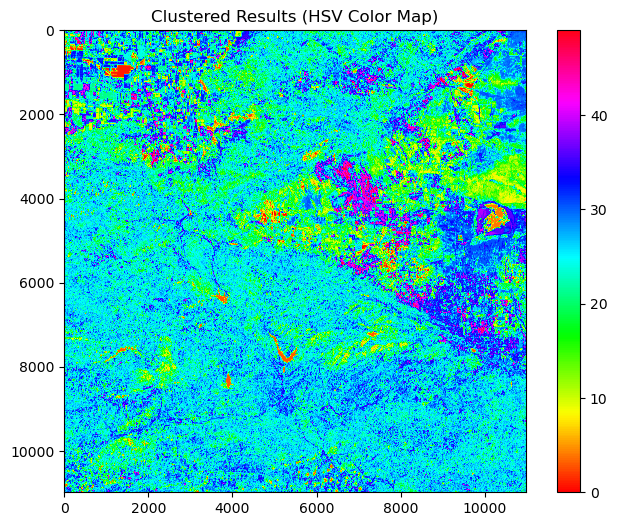

Processed and saved: clustered_result\T11SLU_20250117T183619\T11SLU_20250117T183619.tif


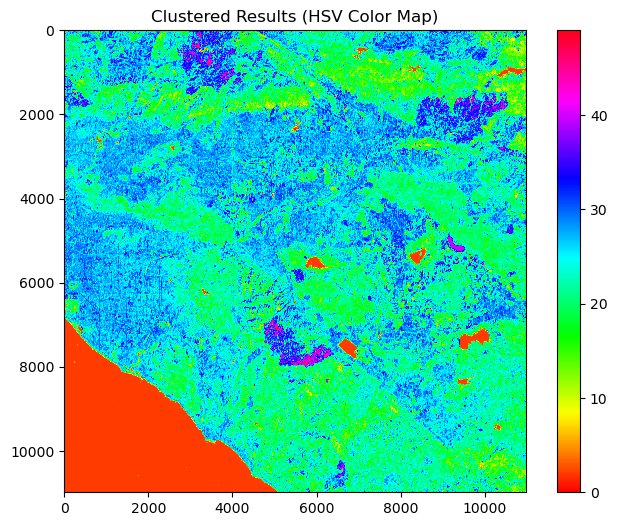

Processed and saved: clustered_result\T11SMT_20250112T183731\T11SMT_20250112T183731.tif


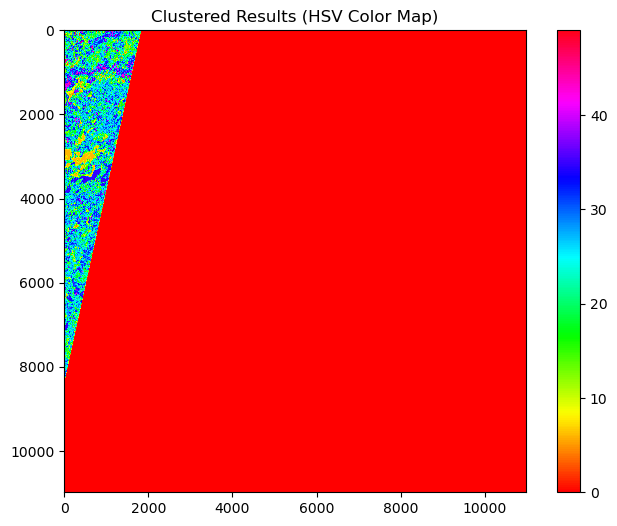

Processed and saved: clustered_result\T47PRN_20250204T034001\T47PRN_20250204T034001.tif


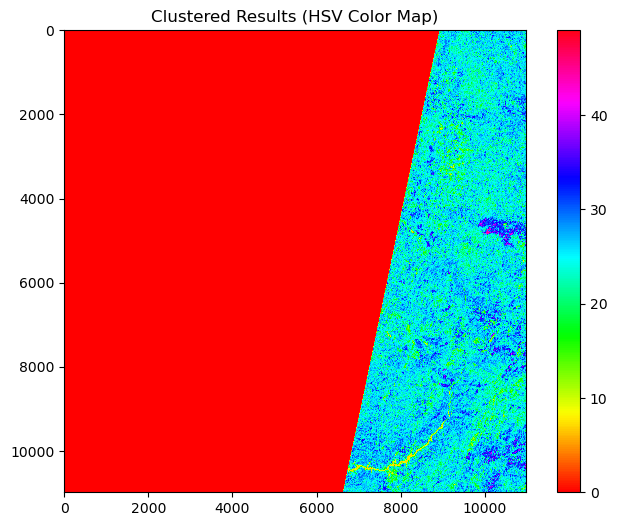

Processed and saved: clustered_result\T47QPA_20250204T034001\T47QPA_20250204T034001.tif


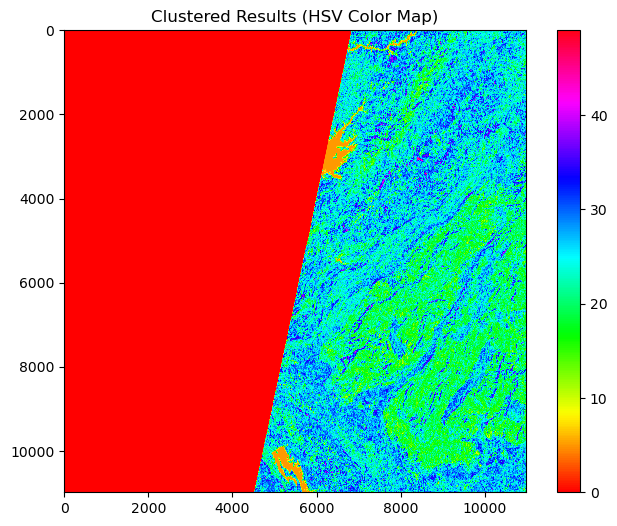

Processed and saved: clustered_result\T47QPV_20250204T034001\T47QPV_20250204T034001.tif


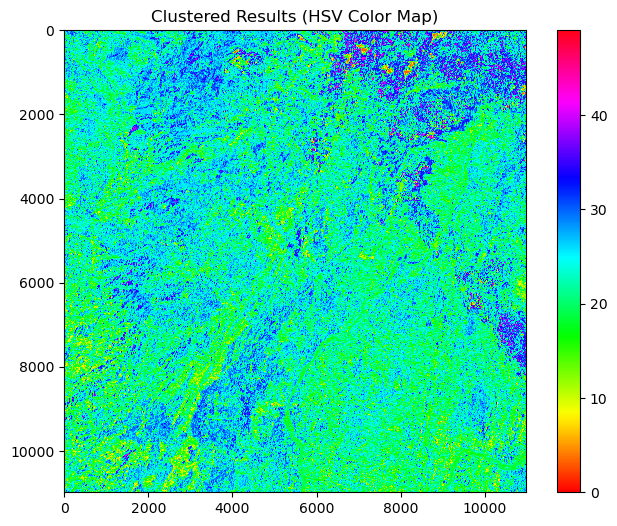

Processed and saved: clustered_result\T47QQA_20250204T034001\T47QQA_20250204T034001.tif


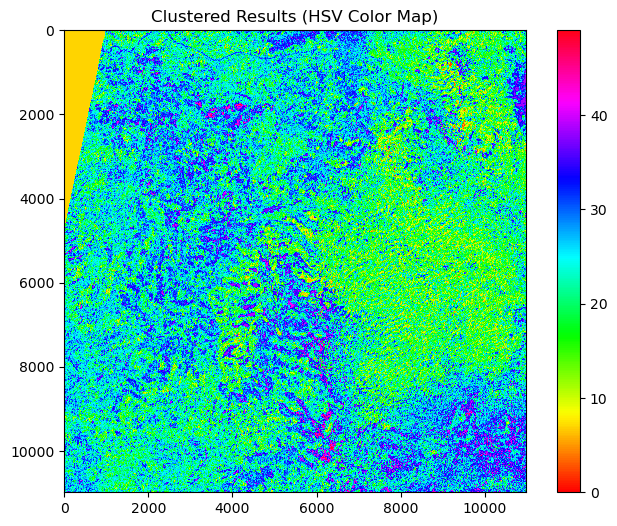

Processed and saved: clustered_result\T47QQB_20250204T034001\T47QQB_20250204T034001.tif


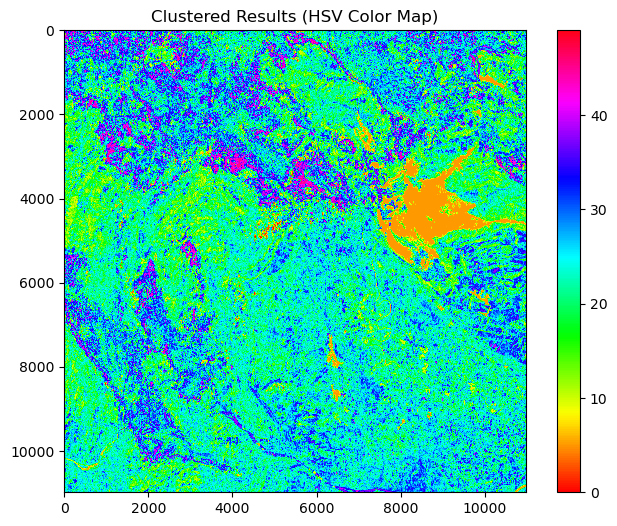

Processed and saved: clustered_result\T47QRA_20250204T034001\T47QRA_20250204T034001.tif


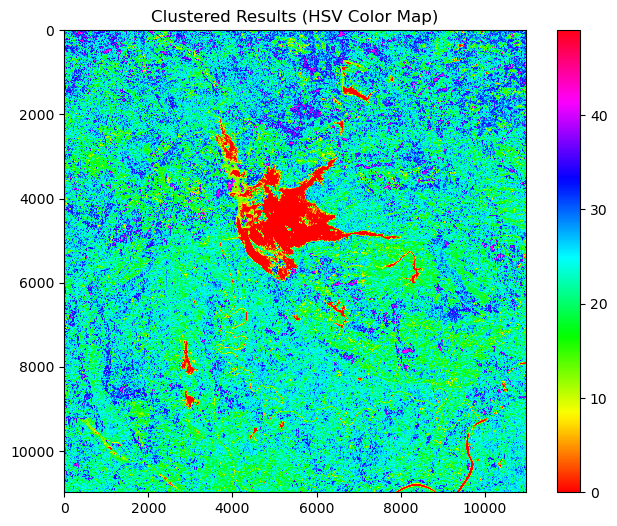

Processed and saved: clustered_result\T48QTF_20250204T034001\T48QTF_20250204T034001.tif


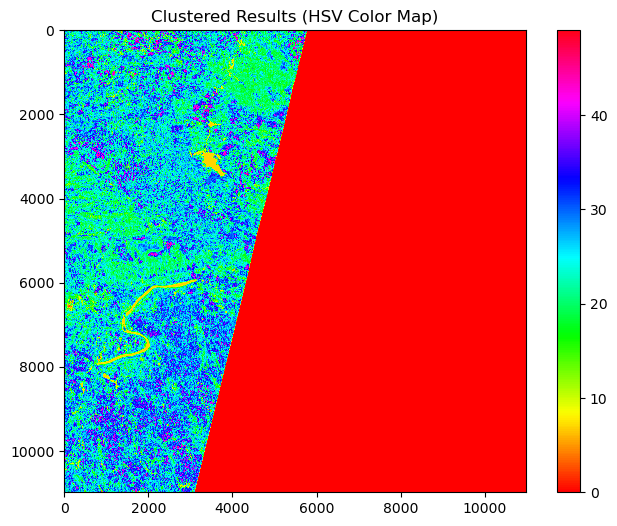

Processed and saved: clustered_result\T48QUF_20250204T034001\T48QUF_20250204T034001.tif


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn import cluster
from osgeo import gdal, gdal_array

# Set the root directory where your .tif files are located
root_dir = "Raster_Classified"
output_dir = "clustered_result"
os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

# Function to process a single raster file
def process_raster(file_path, output_path):
    try:
        # Open raster file
        ds = gdal.Open(file_path, gdal.GA_ReadOnly)
        if ds is None:
            print(f"Could not open {file_path}")
            return
        
        img = np.zeros((ds.RasterYSize, ds.RasterXSize, ds.RasterCount),
                       gdal_array.GDALTypeCodeToNumericTypeCode(ds.GetRasterBand(1).DataType))
        
        for b in range(img.shape[2]):
            img[:, :, b] = ds.GetRasterBand(b + 1).ReadAsArray()
        
        # Reshape for clustering
        new_shape = (img.shape[0] * img.shape[1], img.shape[2])
        X = img[:, :, :14].reshape(new_shape)
        
        # Handle NaN values
        X_filled = np.nan_to_num(X, nan=0)
        
        # Apply k-means clustering
        k_means = cluster.KMeans(n_clusters=50, max_iter=50, random_state=42)
        k_means.fit(X_filled)
        X_cluster = k_means.labels_.reshape(img[:, :, 0].shape)
        
        # Save clustered image
        band = ds.GetRasterBand(1)
        rows, cols = band.ReadAsArray().shape
        driver = gdal.GetDriverByName("GTiff")
        out_raster = driver.Create(output_path, cols, rows, 1, gdal.GDT_Byte)
        out_raster.SetGeoTransform(ds.GetGeoTransform())
        out_raster.SetProjection(ds.GetProjection())
        out_raster.GetRasterBand(1).WriteArray(X_cluster)
        out_raster.FlushCache()
        
        del out_raster
        del ds

        # Plot the clustered results
        plt.figure(figsize=(8, 6))
        plt.imshow(X_cluster, cmap='hsv')
        plt.colorbar()
        plt.title("Clustered Results (HSV Color Map)")
        plt.show()

        print(f"Processed and saved: {output_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Loop through all .tif files in the root directory and subdirectories
for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith(".tif"):
            file_path = os.path.join(subdir, file)
            relative_path = os.path.relpath(file_path, root_dir)
            output_path = os.path.join(output_dir, relative_path)
            os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Ensure directory exists
            process_raster(file_path, output_path)